<a href="https://colab.research.google.com/github/fsclsnow/AML/blob/master/AML_Project6_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 6 - Team 2
Joe, Getong, Abby

In this project, the following items were performed.

1) Select 4 types of image data: Bridge, House, Miss America, Europe

2) For each dataset, cluster the images using K-Means and plot the elbow graph to show the best K.

3) Train a classifier to determine which object is represented in each image and evaluate it on the validation set.

4) Use K-Means as a dimensionality reduction tool and train a classifier on the reduced set. Search for the number of clusters that provides the best performance.

5) Train a Gaussian mixture model  on each dataset. To speed up the algorithm, use PCA dimensionality reduction (99% variataion).

6) Graph results of your experiments for the different data sets and provide a qualitative assessment and detailed discussion of the achieved results.


# Setup

In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import urllib
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.mixture import GaussianMixture

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [0]:
# Download the bridge image
PROJECT_ROOT_DIR = "."
images_path = os.path.join(PROJECT_ROOT_DIR,"Data")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/fsclsnow/AML/master/"
fn_bridge = "bridge.pgm"
print("Downloading", fn_bridge)
url_b = DOWNLOAD_ROOT + "Data/" + fn_bridge
urllib.request.urlretrieve(url_b, os.path.join(images_path, fn_bridge))
fn_house = "house.ppm"
print("Downloading", fn_house)
url_h = DOWNLOAD_ROOT + "Data/" + fn_house
urllib.request.urlretrieve(url_h, os.path.join(images_path, fn_house))
fn_missa = "missa001.pgm"
print("Downloading", fn_missa)
url_m = DOWNLOAD_ROOT + "Data/" + fn_missa
urllib.request.urlretrieve(url_m, os.path.join(images_path, fn_missa))

('./Data/missa001.pgm', <http.client.HTTPMessage at 0x7f66827340f0>)

In [0]:
from matplotlib.image import imread
import cv2
image_b = imread(os.path.join(images_path, fn_bridge))
image_b.shape

(256, 256)

In [0]:
X = image_b.reshape(-1,1)
X.shape

(65536, 1)

In [0]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

Saving figure image_segmentation_diagram


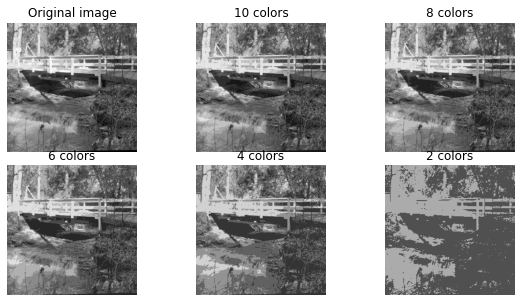

In [0]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image_b,cmap='gray', vmin=0, vmax=255)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx],cmap='gray', vmin=0, vmax=255)
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

save_fig('image_segmentation_diagram', tight_layout=False)
plt.show()

The more clusters there are, the closer each instance will be to its closest centroid, and therefore the lower the inertia will be. However, we can plot the inertia as a function of  k  and analyze the resulting curve:

In [0]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

In [0]:
inertias 

[184851751.92749023,
 57641703.42358245,
 28928468.326483205,
 17067104.762647353,
 10960378.3893934,
 7712322.340757762,
 5784255.758402037,
 4439077.315486512,
 3555877.8995346352]

Saving figure inertia_vs_k_plot


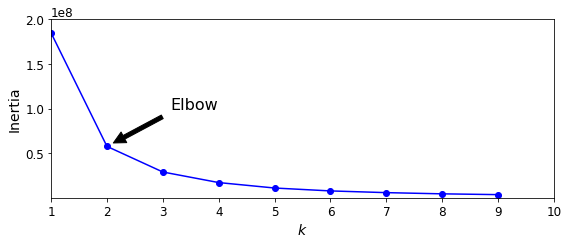

In [0]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(2, inertias[1]),
             xytext=(0.3, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 10, 1, 200000000])
save_fig("inertia_vs_k_plot")
plt.show()

Another approach is to look at the silhouette score, which is the mean silhouette coefficient over all the instances. An instance's silhouette coefficient is equal to  (b−a)/max(a,b)  where  a  is the mean distance to the other instances in the same cluster (it is the mean intra-cluster distance), and  b  is the mean nearest-cluster distance, that is the mean distance to the instances of the next closest cluster (defined as the one that minimizes  b , excluding the instance's own cluster). The silhouette coefficient can vary between -1 and +1: a coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to -1 means that the instance may have been assigned to the wrong cluster.

In [0]:
from sklearn.metrics import silhouette_score

In [0]:
silhouette_score(X, kmeans.labels_)

0.5993002288824801

In [0]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

Saving figure silhouette_score_vs_k_plot


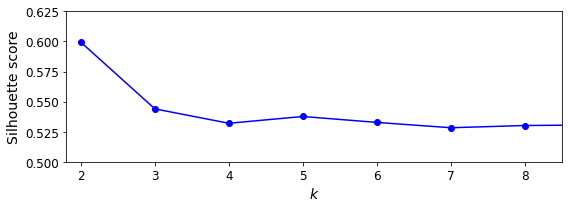

In [0]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.5, 0.625])
save_fig("silhouette_score_vs_k_plot")
plt.show()

Saving figure silhouette_analysis_plot


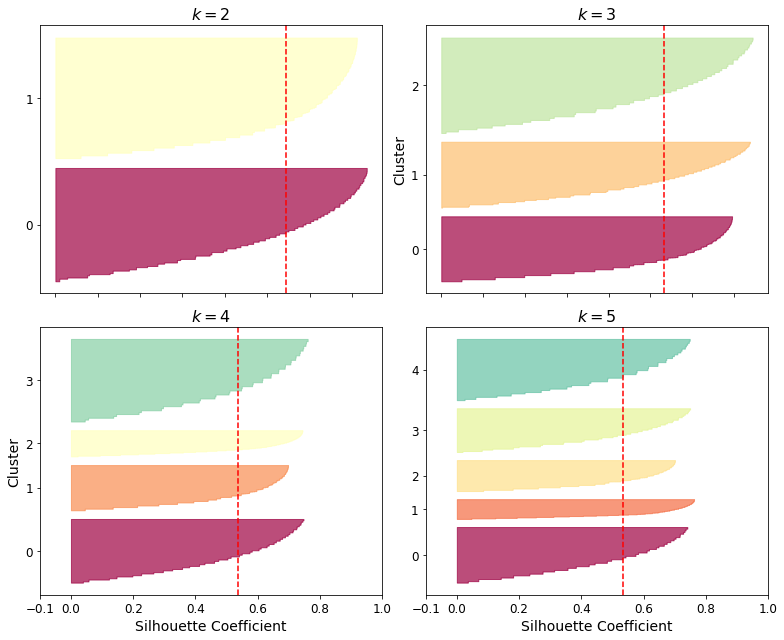

In [0]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (2, 3, 4, 5):
    plt.subplot(2, 2, k - 1)
    
    y_pred = kmeans_per_k[k - 0].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 4):
        plt.ylabel("Cluster")
    
    if k in (4, 5):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 1], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

save_fig("silhouette_analysis_plot")
plt.show()

Therefore, the best K is 2.

# House

In [0]:
urllib.request.urlretrieve(url_h, os.path.join(images_path, fn_house))
image_h = imread(os.path.join(images_path, fn_house))
image_h.shape

(256, 256, 3)

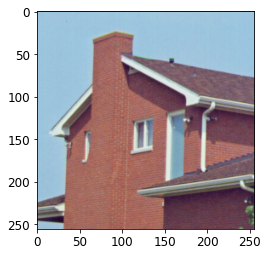

In [0]:
plt.imshow(image_h)

In [0]:
H = image_h.reshape(-1,3)
H.shape

(65536, 3)

In [0]:
H = H.astype('float32') / 255.0
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(H)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image_h.shape))

Saving figure image_segmentation_diagram


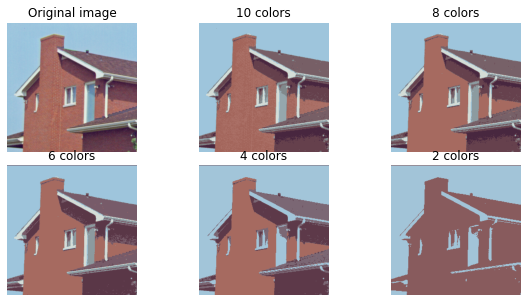

In [0]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.subplot(231)
plt.imshow(image_h)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

save_fig('image_segmentation_diagram', tight_layout=False)
plt.show()

In [0]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(H)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

In [0]:
inertias

[8144.3257,
 1712.70838488524,
 853.9689279798686,
 662.6968560506401,
 512.2930972477599,
 391.28052635745297,
 294.6351556875832,
 238.59932350018437,
 211.30342779416026]

Saving figure inertia_vs_k_plot


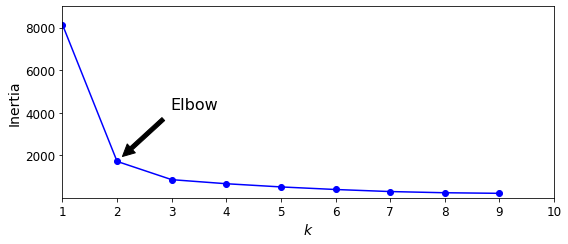

In [0]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(2, inertias[1]),
             xytext=(0.3, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 10, 1, 9000])
save_fig("inertia_vs_k_plot")
plt.show()

In [0]:
silhouette_score(H, kmeans.labels_)

0.72808146

In [0]:
silhouette_scores = [silhouette_score(H, model.labels_)
                     for model in kmeans_per_k[1:]]

Saving figure silhouette_score_vs_k_plot


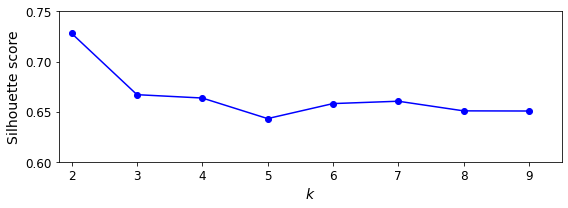

In [0]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 9.5, 0.6, 0.75])
save_fig("silhouette_score_vs_k_plot")
plt.show()

Saving figure silhouette_analysis_plot


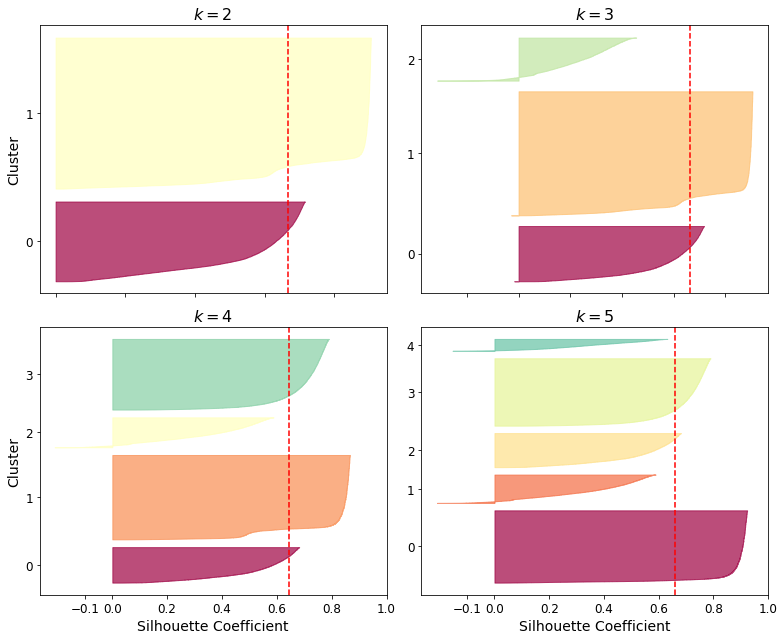

In [0]:
plt.figure(figsize=(11, 9))

for k in (2, 3, 4, 5):
    plt.subplot(2, 2, k - 1)
    
    y_pred = kmeans_per_k[k - 0].labels_
    silhouette_coefficients = silhouette_samples(H, y_pred)

    padding = len(H) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (2, 4):
        plt.ylabel("Cluster")
    
    if k in (4, 5):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 1], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

save_fig("silhouette_analysis_plot")
plt.show()

Therefore, the best K is 2.

# Miss America

In [0]:
urllib.request.urlretrieve(url_m, os.path.join(images_path, fn_missa))
image_m = imread(os.path.join(images_path, fn_missa))
image_m.shape

(288, 360)

In [0]:
M = image_m.reshape(-1,1)
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(M)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image_m.shape))

Saving figure image_segmentation_diagram


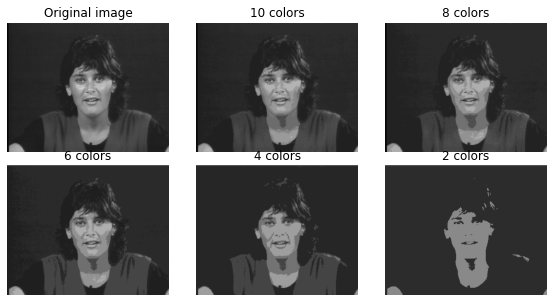

In [0]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image_m,cmap='gray', vmin=0, vmax=255)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx],cmap='gray', vmin=0, vmax=255)
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

save_fig('image_segmentation_diagram', tight_layout=False)
plt.show()

In [0]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(M)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]
inertias

[118332645.24070214,
 24435828.92519524,
 11068244.194577836,
 6443964.15019304,
 4735978.514373256,
 3633122.328406413,
 2878640.285137444,
 2241107.559510076,
 1808731.3017511007]

Saving figure inertia_vs_k_plot


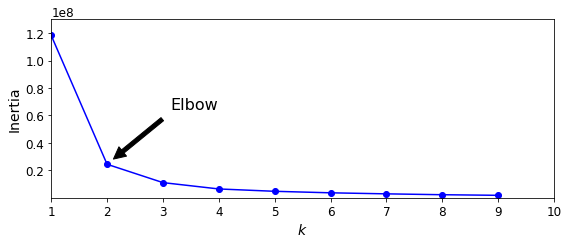

In [0]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(2, inertias[1]),
             xytext=(0.3, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 10, 1, 130000000])
save_fig("inertia_vs_k_plot")
plt.show()

In [0]:
silhouette_score(M, kmeans.labels_)

0.8143210733972407

In [0]:
silhouette_scores = [silhouette_score(M, model.labels_)
                     for model in kmeans_per_k[1:]]

Saving figure silhouette_score_vs_k_plot


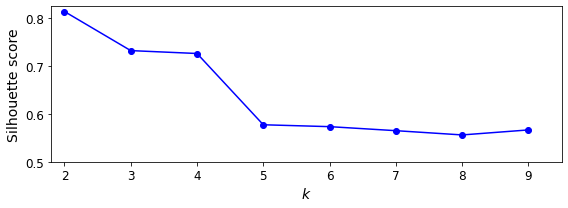

In [0]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 9.5, 0.5, 0.825])
save_fig("silhouette_score_vs_k_plot")
plt.show()

Saving figure silhouette_analysis_plot


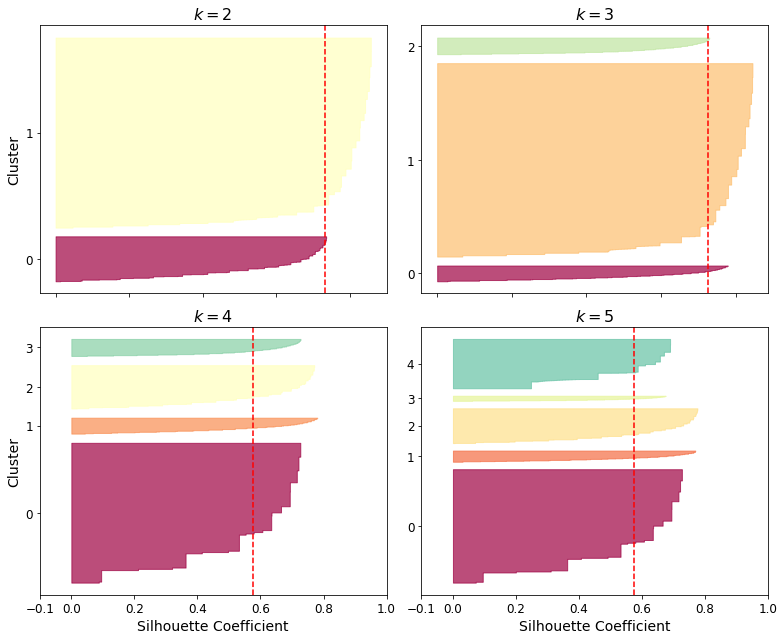

In [0]:
plt.figure(figsize=(11, 9))

for k in (2, 3, 4, 5):
    plt.subplot(2, 2, k - 1)
    
    y_pred = kmeans_per_k[k - 0].labels_
    silhouette_coefficients = silhouette_samples(M, y_pred)

    padding = len(M) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (2, 4):
        plt.ylabel("Cluster")
    
    if k in (4, 5):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 1], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

save_fig("silhouette_analysis_plot")
plt.show()

Therefore, the best K is 2.

# Europe

In [0]:
fn_europe = "europe.png"
url_e = DOWNLOAD_ROOT + "Data/" + fn_europe
urllib.request.urlretrieve(url_e, os.path.join(images_path, fn_europe))
image_e = imread(os.path.join(images_path, fn_europe))
image_e.shape


(858, 875)

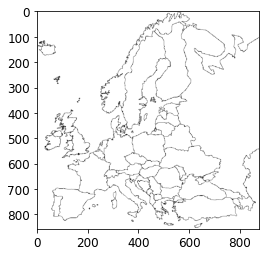

In [0]:
image_e = image_e.astype('float32') / 1.0
plt.imshow(image_e,cmap='gray', vmin=0, vmax=1.0)

In [0]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(E)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]
inertias

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  
/usr/local/lib/python3.6/dist-packa

[23102.635,
 0.00018450904825206838,
 2.901297779800416e-06,
 2.901297779800416e-06,
 2.901297779800416e-06,
 2.901297779800416e-06,
 2.901297779800416e-06,
 2.901297779800416e-06,
 2.901297779800416e-06]

Saving figure inertia_vs_k_plot


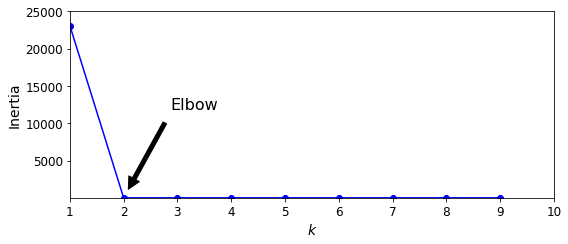

In [0]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(2, inertias[1]),
             xytext=(0.3, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 10, 1,25000])
save_fig("inertia_vs_k_plot")
plt.show()

This is a binary image, basically means there are only two distinct value for its pixels, therefore, there is only two cluster existing in this data set. 

# PCA Reduction

In [0]:
from sklearn.decomposition import PCA
pca=PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.99) + 1
cumsum

array([1.])

In [0]:
d

1

In [0]:
URL = "http://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-100/coil-100.zip"

In [1]:
!wget http://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-100/coil-100.zip -O /content/coil-100.zip

--2020-04-08 15:03:13--  http://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-100/coil-100.zip
Resolving www.cs.columbia.edu (www.cs.columbia.edu)... 128.59.11.206
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-100/coil-100.zip [following]
--2020-04-08 15:03:13--  https://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-100/coil-100.zip
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 130688843 (125M) [application/zip]
Saving to: ‘/content/coil-100.zip’

/content/coil-100.z 100%[===================>] 124.63M  50.1MB/s    in 2.5s    

2020-04-08 15:03:16 (50.1 MB/s) - ‘/content/coil-100.zip’ saved [130688843/130688843]



In [2]:
!ls

coil-100.zip  sample_data


In [0]:
import os
import zipfile
local_zip = '/content/coil-100.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/content/coil')
zip_ref.close()

In [10]:
coil_dir = os.path.join('/content/coil/coil-100')
print('total training images:', len(os.listdir(coil_dir)))

total training images: 7200


In [0]:
!rm /content/coil/coil-100/convertGroupppm2png.pl

In [0]:
!rm /content/coil/coil-100/convertGroupppm2png.pl~

In [11]:
coil_files = os.listdir(coil_dir)
print(coil_files[:10])

['obj64__150.png', 'obj28__175.png', 'obj80__60.png', 'obj58__105.png', 'obj5__85.png', 'obj44__110.png', 'obj45__330.png', 'obj53__250.png', 'obj8__350.png', 'obj62__145.png']


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
data = []

next_coil = [os.path.join(coil_dir, fname) for fname in coil_files]
for i, img_path in enumerate(next_coil):
    img = mpimg.imread(img_path)
    data.append(img)

In [14]:
import numpy as np

data_i = np.asarray(data)
data_i.shape

(7200, 128, 128, 3)

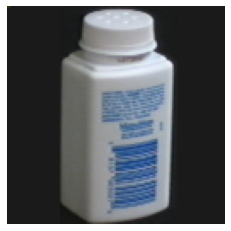

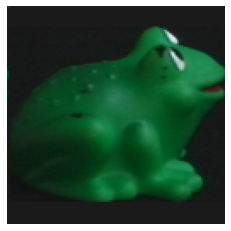

In [6]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 2
data = []
next_coil = [os.path.join(coil_dir, fname) for fname in coil_files[pic_index-2:pic_index]]
for i, img_path in enumerate(next_coil):
    #print(img_path)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('Off')
    plt.show()

In [0]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

TRAINING_DIR = "/content/coil/"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	  rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

In [24]:
train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(128,128),
	class_mode='categorical'
)

Found 7200 images belonging to 1 classes.


In [0]:
data = np.asarray(train_generator)

In [0]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)

Using TensorFlow backend.


KeyboardInterrupt: ignored